# Load data

In [60]:
import numpy as np
fast_model_fast_data = np.load("nighttime_ai_fast_synth_model_fast_synth_data_activations.npy")
fast_model_slow_data = np.load("nighttime_ai_fast_synth_model_slow_data_activations.npy")
slow_model_fast_data = np.load("nighttime_ai_slow_model_fast_synth_data_activations.npy")
slow_model_slow_data = np.load("nighttime_ai_slow_model_slow_data_activations.npy")


[d.shape for d in (fast_model_fast_data, fast_model_slow_data, slow_model_fast_data, slow_model_slow_data)]

[(10150, 256), (10150, 256), (10150, 256), (10150, 256)]

# Find N for Kmeans

In [34]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import time

d = dict()


def f(name, data, name_kmeans):
    inertias = {}
    for n in range(2, 10):
        t0 = time.time()
        model = KMeans(n_clusters=n, random_state=0).fit(data)
        inertia = model.inertia_
        print(
            f'Getting kmeans with {n} clusters for {name} dataset took {time.time() - t0} seconds. Inertia is {inertia}.')
        inertias[n] = inertia
    name_kmeans[name] = inertias


f('fast_model_fast_data', fast_model_fast_data, d)
f('fast_model_slow_data', fast_model_slow_data, d)
f('slow_model_fast_data', slow_model_fast_data, d)
f('slow_model_slow_data', slow_model_slow_data, d)
d

Getting kmeans with 2 clusters for fast_model_fast_data dataset took 0.37409305572509766 seconds. Inertia is 431761.73373687314.
Getting kmeans with 3 clusters for fast_model_fast_data dataset took 0.42429399490356445 seconds. Inertia is 390795.7237736633.
Getting kmeans with 4 clusters for fast_model_fast_data dataset took 0.3703031539916992 seconds. Inertia is 361540.4076756872.
Getting kmeans with 5 clusters for fast_model_fast_data dataset took 0.49153995513916016 seconds. Inertia is 328408.62058624194.
Getting kmeans with 6 clusters for fast_model_fast_data dataset took 0.7634479999542236 seconds. Inertia is 302679.8972052501.
Getting kmeans with 7 clusters for fast_model_fast_data dataset took 0.6650998592376709 seconds. Inertia is 276999.58208317263.
Getting kmeans with 8 clusters for fast_model_fast_data dataset took 0.5114541053771973 seconds. Inertia is 251696.33989423723.
Getting kmeans with 9 clusters for fast_model_fast_data dataset took 0.7198672294616699 seconds. Inertia

{'fast_model_fast_data': {2: 431761.73373687314,
  3: 390795.7237736633,
  4: 361540.4076756872,
  5: 328408.62058624194,
  6: 302679.8972052501,
  7: 276999.58208317263,
  8: 251696.33989423723,
  9: 231469.7141768251},
 'fast_model_slow_data': {2: 256835.81526999013,
  3: 190325.95865448855,
  4: 153858.65962932067,
  5: 123320.14579537365,
  6: 105691.46897013161,
  7: 96347.54941777258,
  8: 87818.43129193879,
  9: 81537.0626832294},
 'slow_model_fast_data': {2: 262907.91950867197,
  3: 218453.354106166,
  4: 175126.23196822242,
  5: 151188.93730531266,
  6: 131936.99914350672,
  7: 116496.93648961958,
  8: 105812.4457969107,
  9: 99211.34035159374},
 'slow_model_slow_data': {2: 472841.21604160394,
  3: 424407.8232971073,
  4: 389699.1414761313,
  5: 362086.05216198333,
  6: 327314.5417158635,
  7: 302696.51989634923,
  8: 278541.3426568593,
  9: 254187.26796440248}}

40239.875298936735
17120.860808003832
19705.22132296881
43933.96726891094


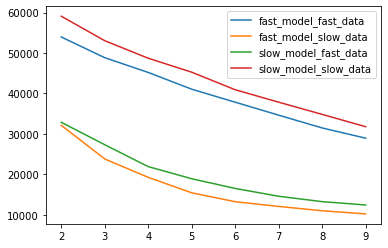

In [35]:

for name, data in d.items():
    data = {k: v for k, v in data.items()}
    average_inertia_over_samples = np.array(list(data.values())) / len(data.values())
    plt.plot(data.keys(), average_inertia_over_samples, label=name)
    print(average_inertia_over_samples.mean())
plt.legend()

# Clustering with N=4

In [36]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

half = int(len(fast_model_fast_data) / 2)
train = fast_model_fast_data[:half, :]
test = fast_model_fast_data[half:half + half, :]
train.shape, test.shape

((5075, 256), (5075, 256))

# Compare train & test & OOD inertias

In [37]:
N = 4

model = KMeans(n_clusters=N, random_state=0)
train_labels = model.fit_predict(train)


def inertia(model, labels, data):
    return np.square(model.cluster_centers_[labels] - data).sum()


# test my inertia function
train_inertia = inertia(model, train_labels, train)
model.inertia_, train_inertia


(176254.30494289816, 176254.30494289822)

In [38]:
test_labels = model.predict(test)

inertia(model, test_labels, test)

181641.9139424827

In [39]:
# Expecting OOD data inertia to be bigger

In [40]:
ood_data = fast_model_slow_data[half:half + half]
ood_labels = model.predict(ood_data)
inertia(model, ood_labels, ood_data)


239943.59999207835

In [41]:
ood_data = fast_model_slow_data[:half]
ood_labels = model.predict(ood_data)
inertia(model, ood_labels, ood_data)


252964.63438468706

# Mahalanobis

In [42]:
def mahalanobis(x, data, cov=None):
    x_mu = x - np.mean(data, axis=0) # or np.mean(data) ?
    if not cov:
        cov = np.cov(data.T)
    inv_covmat = np.linalg.inv(cov)
    left = np.dot(x_mu, inv_covmat)
    mahal = np.dot(left, x_mu.T)
    return mahal.diagonal()

## Fast model

In [43]:
mahalanobis(train, train).mean(), \
mahalanobis(test, train).mean(), \
mahalanobis(fast_model_slow_data, fast_model_fast_data).mean()


(255.9504529557977, 280.5586182822291, 8013.950770906597)

## Slow model

In [44]:
slow_model_train = slow_model_slow_data[:9500]
slow_model_test = slow_model_slow_data[9500:9500 + 9500]

mahalanobis(slow_model_train, slow_model_train).mean(), mahalanobis(slow_model_test, slow_model_train).mean(), mahalanobis(slow_model_fast_data, slow_model_slow_data).mean()


(255.9726080415918, 313.20900539174727, 13864.55858878473)

# How are the samples clustered in these datasets?

In [45]:
import pandas as pd

df = pd.DataFrame(np.array([train_labels, test_labels, ood_labels]).T, columns=['train', 'test', 'ood'])
pd.DataFrame(df.train.value_counts()).merge(df.test.value_counts(), how='outer', right_index=True, left_index=True).merge(df.ood.value_counts(), right_index=True, left_index=True, how='outer').fillna(0).astype(int)

train  test   ood
0    711   705   546
1    444   375     0
2   3311  3298  4430
3    609   697    99

# How much do clusters match ground truth angle classes?

In [46]:
fast_gt = np.load(
    '/Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/synthesized/nighttime-fast-auto-3d-model-nighttime-synth-fast-synth-auto-data-prediction-and-ground-truth.npy')[
          :, 2]

train_gt = fast_gt[:half]
test_gt = fast_gt[half:half + half]
fast_gt.shape, train_gt.shape, test_gt.shape

((10150,), (5075,), (5075,))

In [47]:
slow_gt = np.load(
    '/Users/kristjan.roosild/PycharmProjects/dat-sci-master-thesis/synthesized/nighttime-fast-auto-3d-model-nighttime-synth-slow-auto-data-prediction-and-ground-truth.npy')[
          :, 1]

train_gt = slow_gt[:half]
test_gt = slow_gt[half:half + half]
slow_gt.shape, train_gt.shape, test_gt.shape

((10150,), (5075,), (5075,))

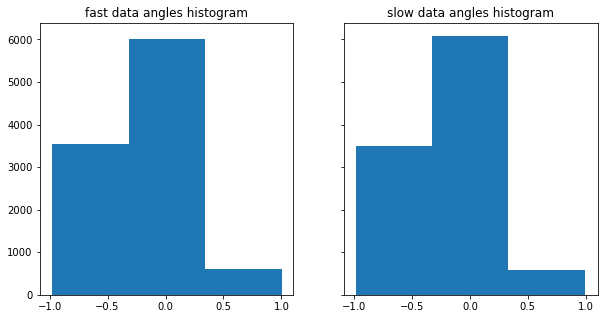

In [48]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5), sharex='all', sharey='all')

axs.flat[0].hist(fast_gt, bins=3)
axs.flat[0].set_title('fast data angles histogram')
axs.flat[1].hist(slow_gt, bins=3)
axs.flat[1].set_title('slow data angles histogram')
plt.show()

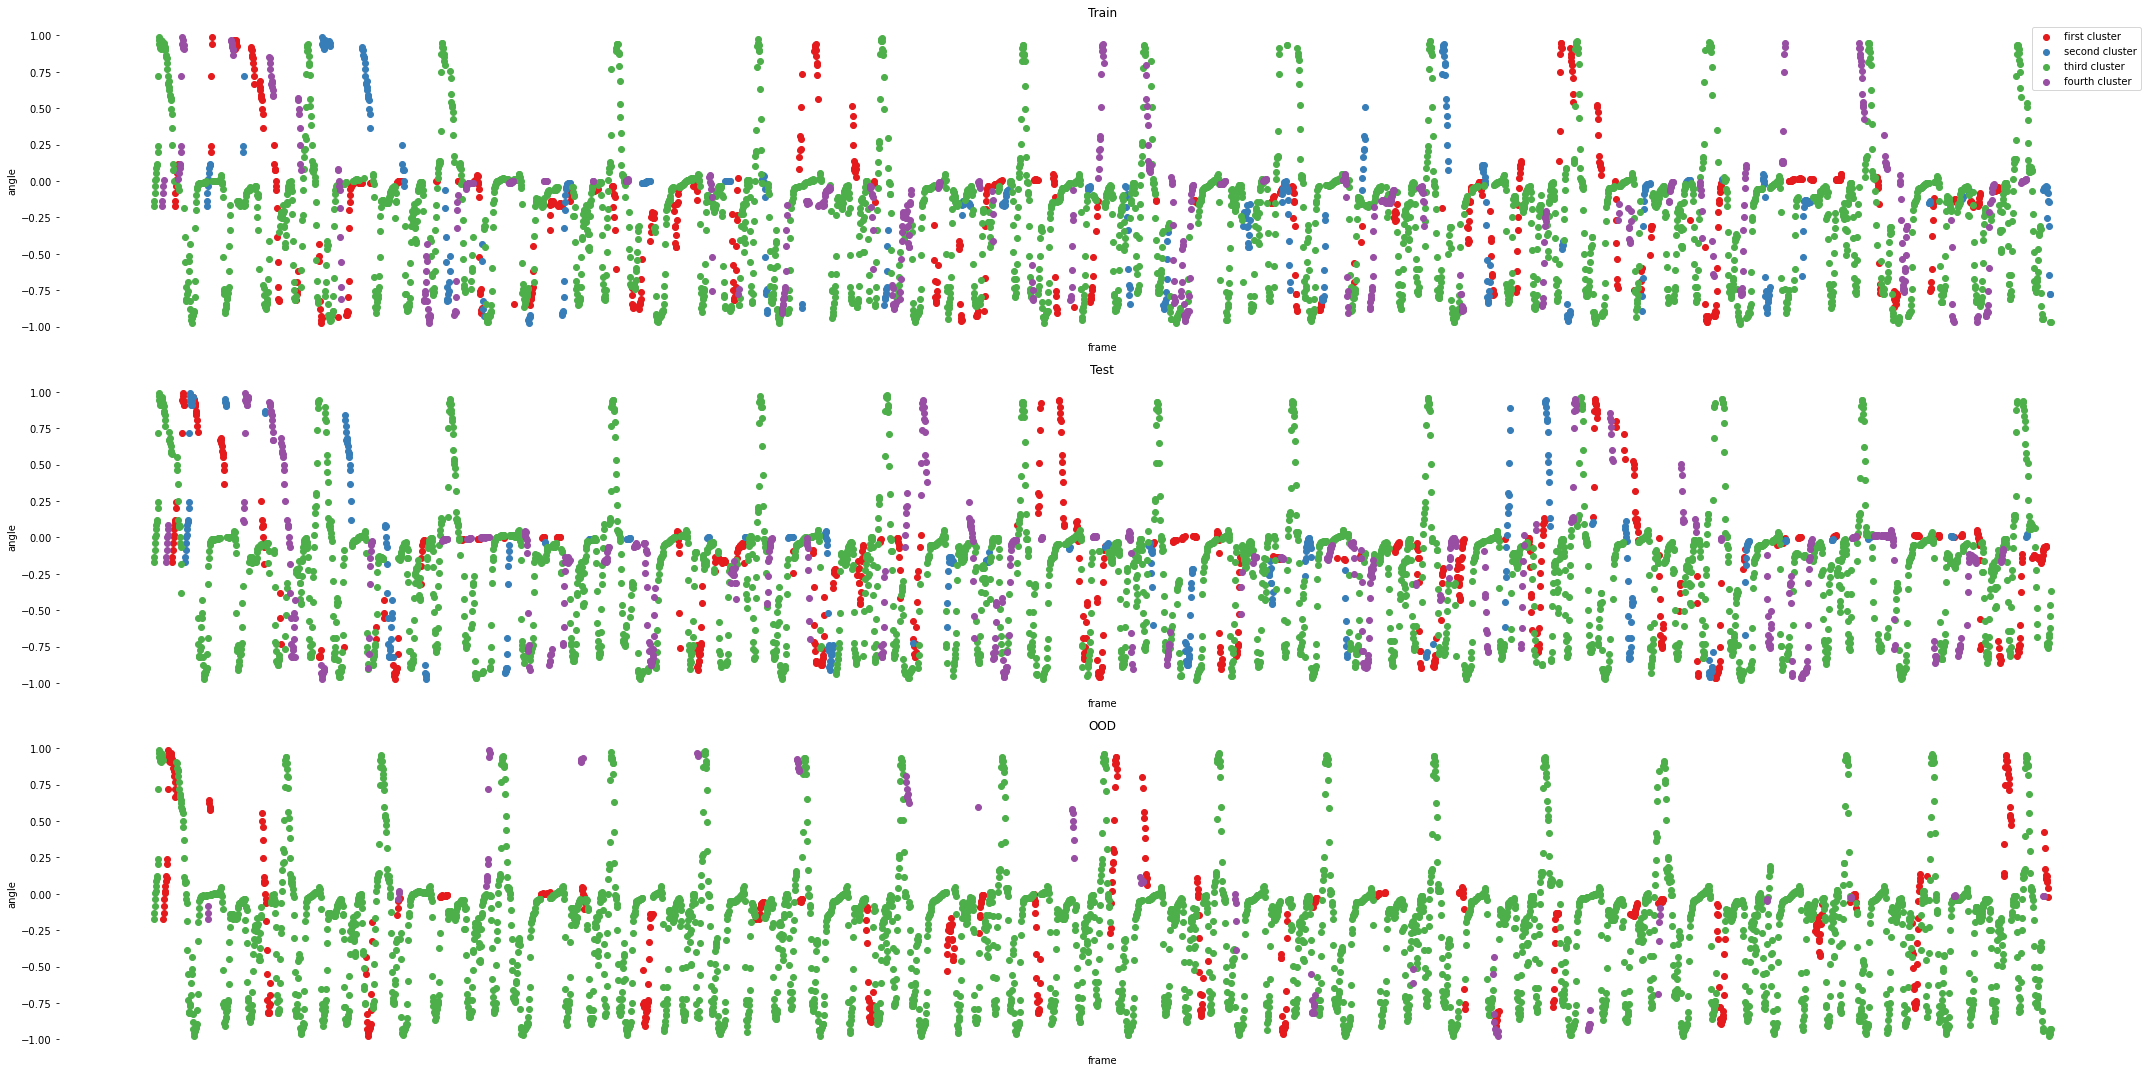

In [49]:
import matplotlib as mpl
cmap = mpl.cm.Set1

fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(30, 15), sharex='all', sharey='all')

clustermap = {0: 'first', 1: 'second', 2: 'third', 3: 'fourth'}

for ax, labels in zip(axs.flat, [train_labels, test_labels, ood_labels]):
    for n in range(N):
        labels_ = labels[labels == n]
        ax.scatter(np.array(list(range(len(labels))))[labels == n], fast_gt[:len(labels_)], color=cmap(n), label=f'{clustermap[n]} cluster')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.get_xaxis().set_ticks([])
    ax.set(ylabel='angle', xlabel='frame')

axs[0].legend()
axs[0].set_title('Train')
axs[1].set_title('Test')
axs[2].set_title('OOD')
fig.tight_layout()

# assign angles to 3 classes

In [50]:

fast_clazz = np.zeros(len(fast_gt))

fast_clazz[fast_gt < -0.2] = -1
fast_clazz[fast_gt >= -0.2] = 0
fast_clazz[fast_gt > 0.2] = 1

slow_clazz = np.zeros(len(slow_gt))

slow_clazz[slow_gt < -0.2] = -1
slow_clazz[slow_gt >= -0.2] = 0
slow_clazz[slow_gt > 0.2] = 1


In [51]:

def plot_ax(ax, probas, dataset_name):
    bottom = np.zeros(3)
    width = 0.35
    for cluster in ['first', 'second', 'third', 'fourth']:
        cluster_values = []
        angles = ['left', 'center', 'right']
        for angle in angles:
            try:
                value = probas[angle, cluster]
            except KeyError:
                value = 0
            cluster_values.append(value)
        cluster_values = np.array(cluster_values)
        ax.bar(angles, cluster_values, width, bottom=bottom, label=f'{cluster} cluster')
        bottom += cluster_values
    ax.set_ylabel('probability')
    ax.set_title(f'Sample cluster probability in angle classes for {dataset_name} dataset')
    ax.legend()



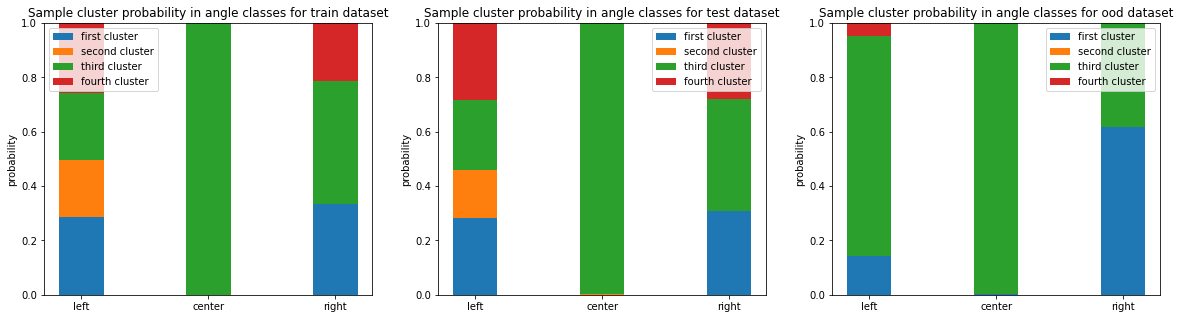

In [52]:
import pandas as pd
def get_probas(clazz, cluster_labels):
    df = pd.DataFrame(np.array([clazz,
                                cluster_labels,
                                np.ones(half)
                                ]).T,
                      columns=['angle_class', 'cluster', 'counts'])
    df["angle_class"].replace({-1: 'left', 0: 'center', 1: 'right'}, inplace=True)
    df["cluster"].replace({0: 'first', 1: 'second', 2: 'third', 3: 'fourth'}, inplace=True)
    return df.groupby('angle_class').cluster.apply(lambda g: g.value_counts() / len(g))


fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
plot_ax(axs[0], get_probas(fast_clazz[:half], train_labels), 'train')
plot_ax(axs[1], get_probas(fast_clazz[half:half+half], test_labels), 'test')
plot_ax(axs[2], get_probas(slow_clazz[:half], ood_labels), 'ood')
plt.show()


# TSNE

In [53]:
from sklearn.manifold import TSNE
low_dim_train = TSNE(n_components=3, random_state=0, learning_rate='auto', init='pca').fit(train)


/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


In [54]:
low_dim_train.embedding_.shape

(5075, 3)

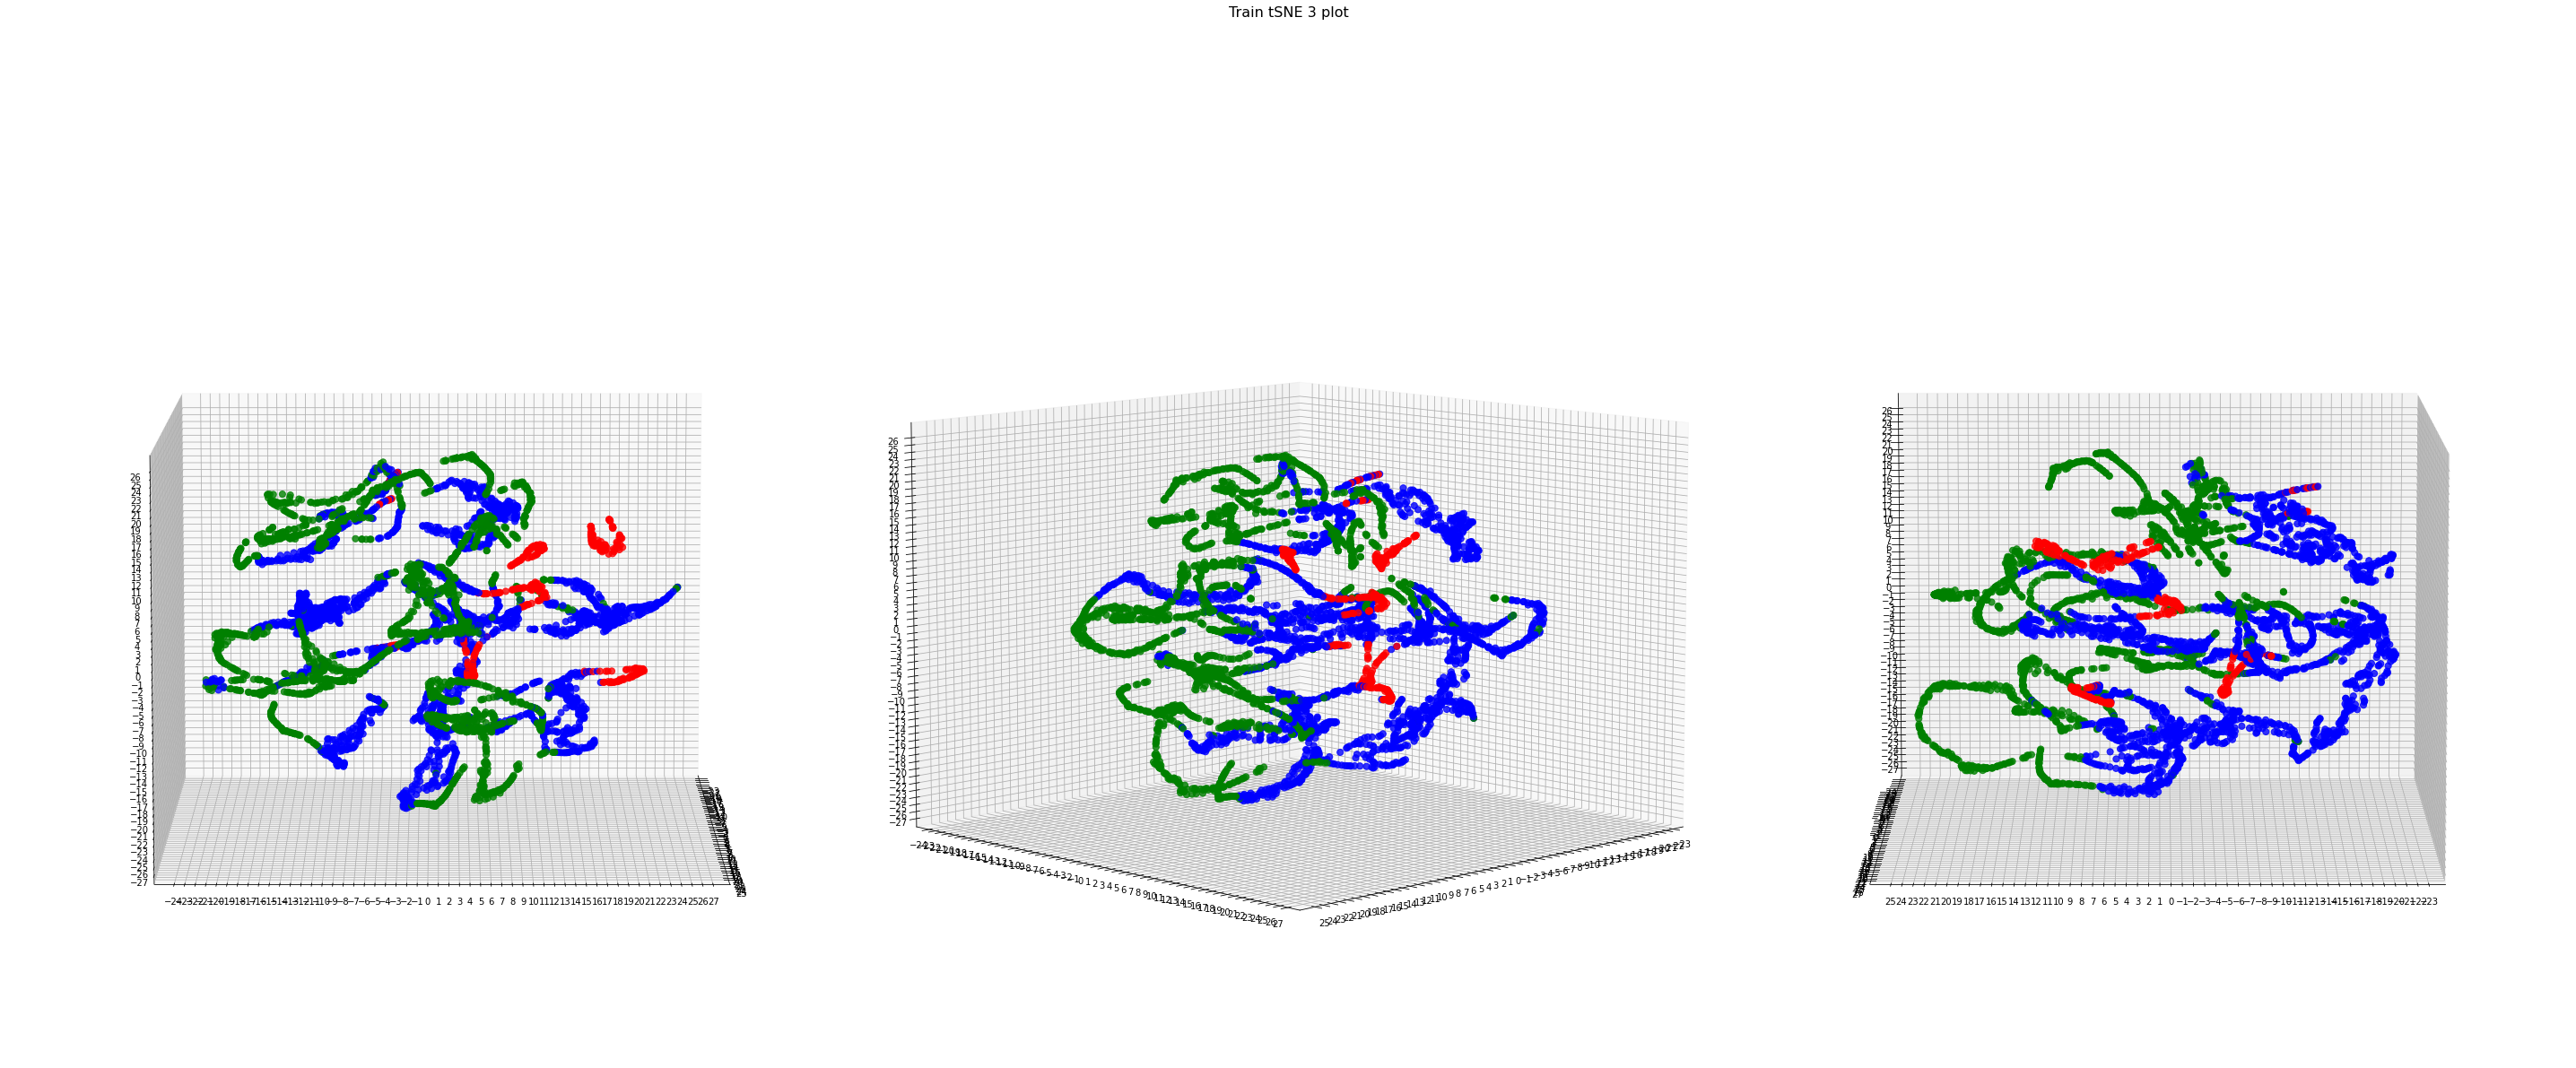

In [55]:
from matplotlib import ticker
import matplotlib

def plot_3d(points, points_color, title):

    x, y, z = points.T

    fig, axs = plt.subplots(
        nrows=1,
        ncols=3,
        figsize=(40, 20),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = axs[0].scatter(x, y, z, c=points_color, s=50, alpha=0.8, cmap=matplotlib.colors.ListedColormap(['green', 'blue', 'red']))
    axs[0].view_init(azim=0, elev=9)
    axs[0].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[0].yaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[0].zaxis.set_major_locator(ticker.MultipleLocator(1))

    col = axs[1].scatter(x, y, z, c=points_color, s=50, alpha=0.8, cmap=matplotlib.colors.ListedColormap(['green', 'blue', 'red']))
    axs[1].view_init(azim=45, elev=9)
    axs[1].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[1].yaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[1].zaxis.set_major_locator(ticker.MultipleLocator(1))

    col = axs[2].scatter(x, y, z, c=points_color, s=50, alpha=0.8, cmap=matplotlib.colors.ListedColormap(['green', 'blue', 'red']))
    axs[2].view_init(azim=90, elev=9)
    axs[2].xaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[2].yaxis.set_major_locator(ticker.MultipleLocator(1))
    axs[2].zaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()

plot_3d(low_dim_train.embedding_, fast_clazz[:half], 'Train tSNE 3 plot')

In [56]:
low_dim_test = TSNE(n_components=3, random_state=0, learning_rate='auto', init='pca').fit(test)

/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


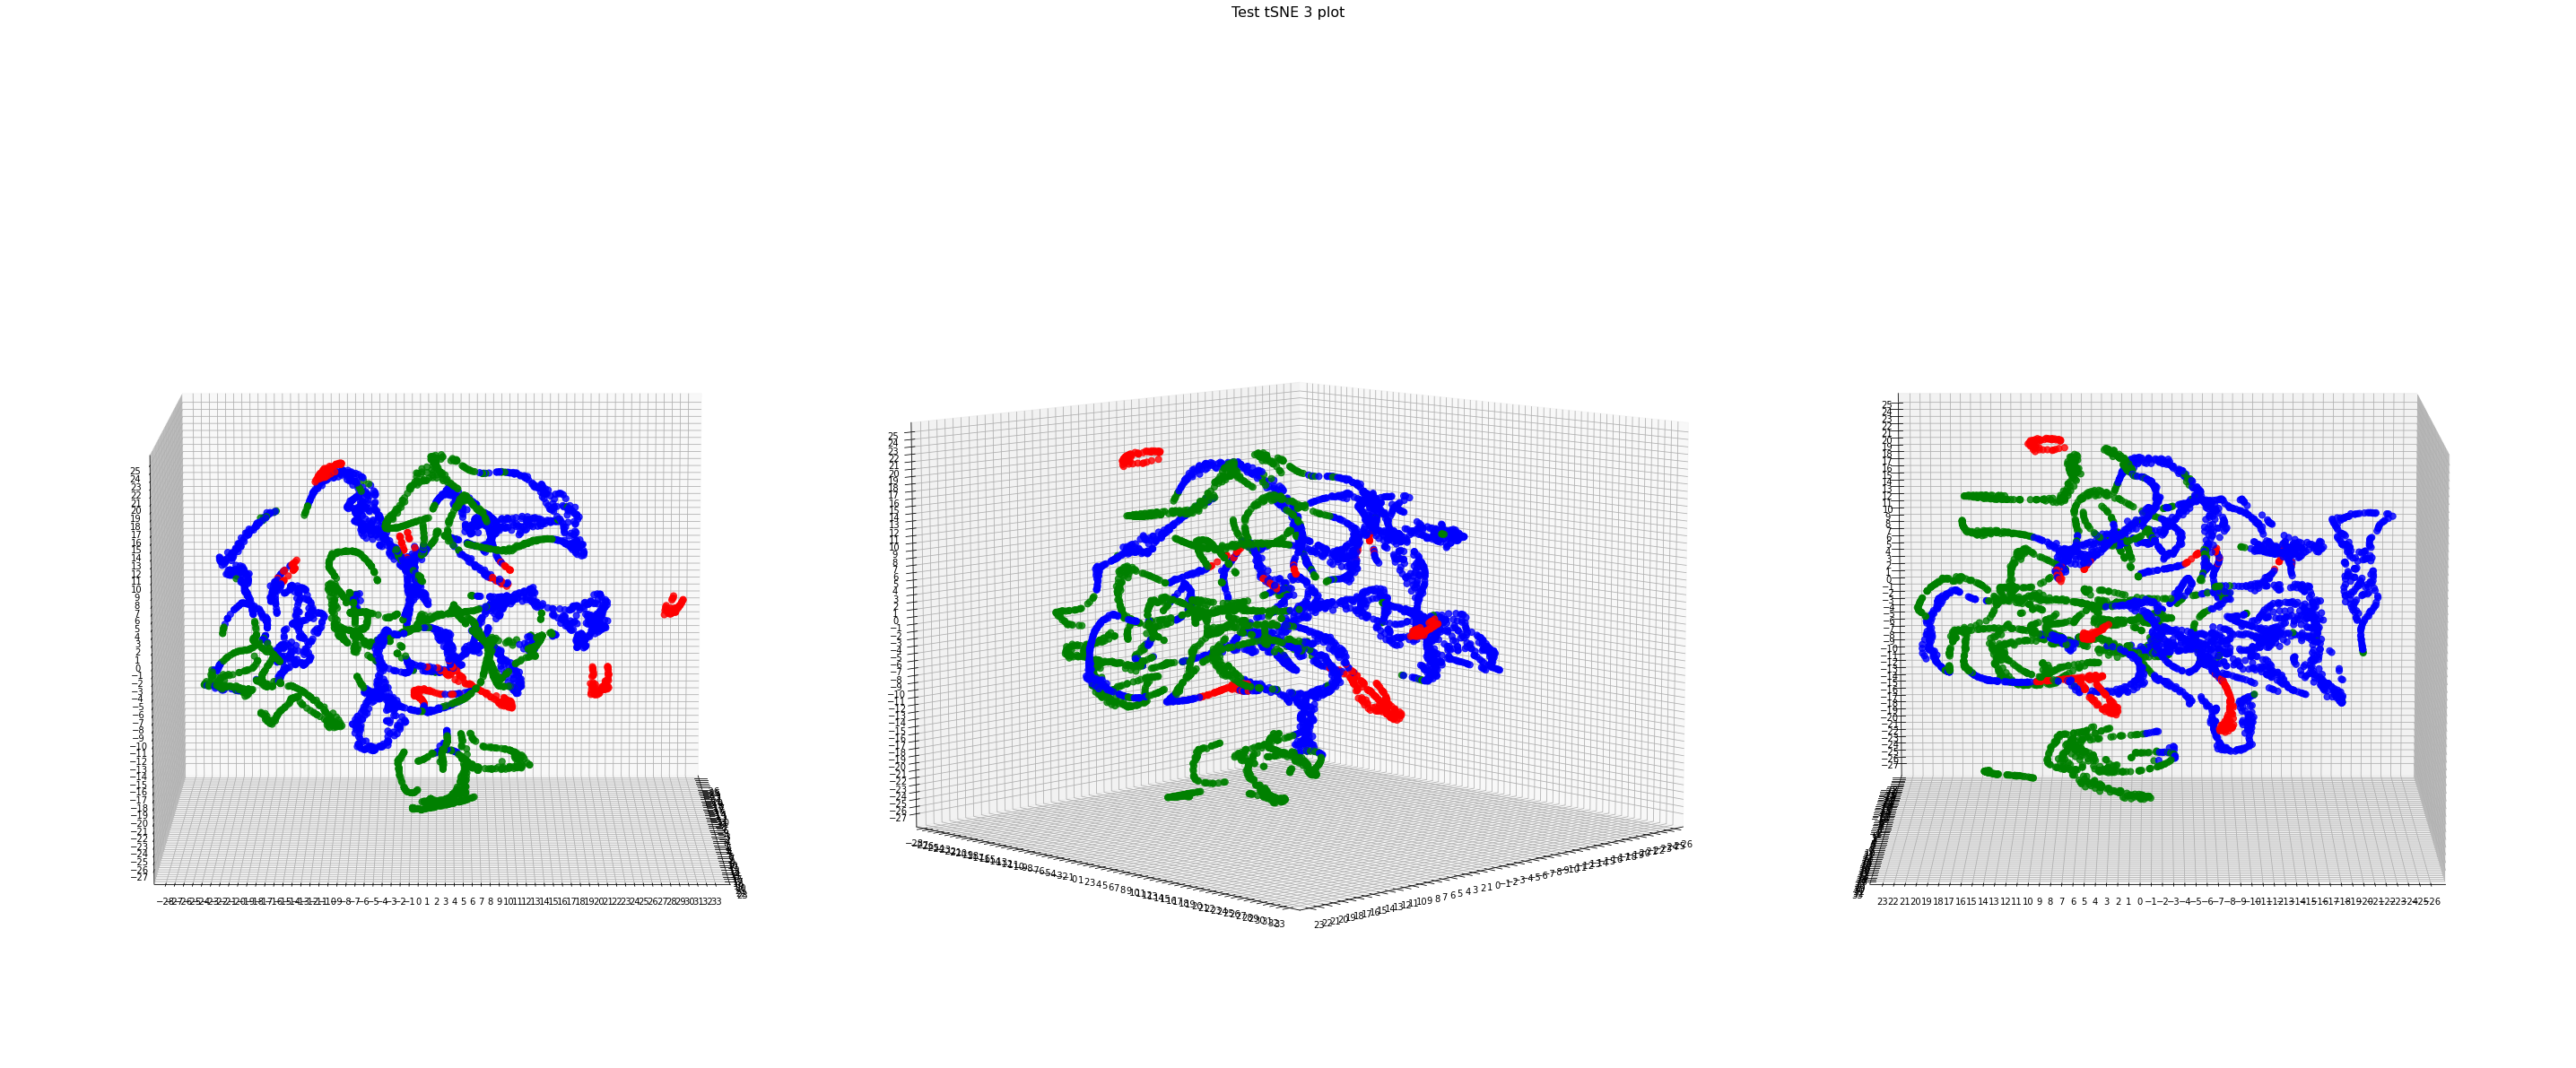

In [57]:
plot_3d(low_dim_test.embedding_, fast_clazz[half:half+half], 'Test tSNE 3 plot')

In [58]:
low_dim_ood = TSNE(n_components=3, random_state=0, learning_rate='auto', init='pca').fit(ood_data)

/Users/kristjan.roosild/opt/miniconda3/envs/donkey/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


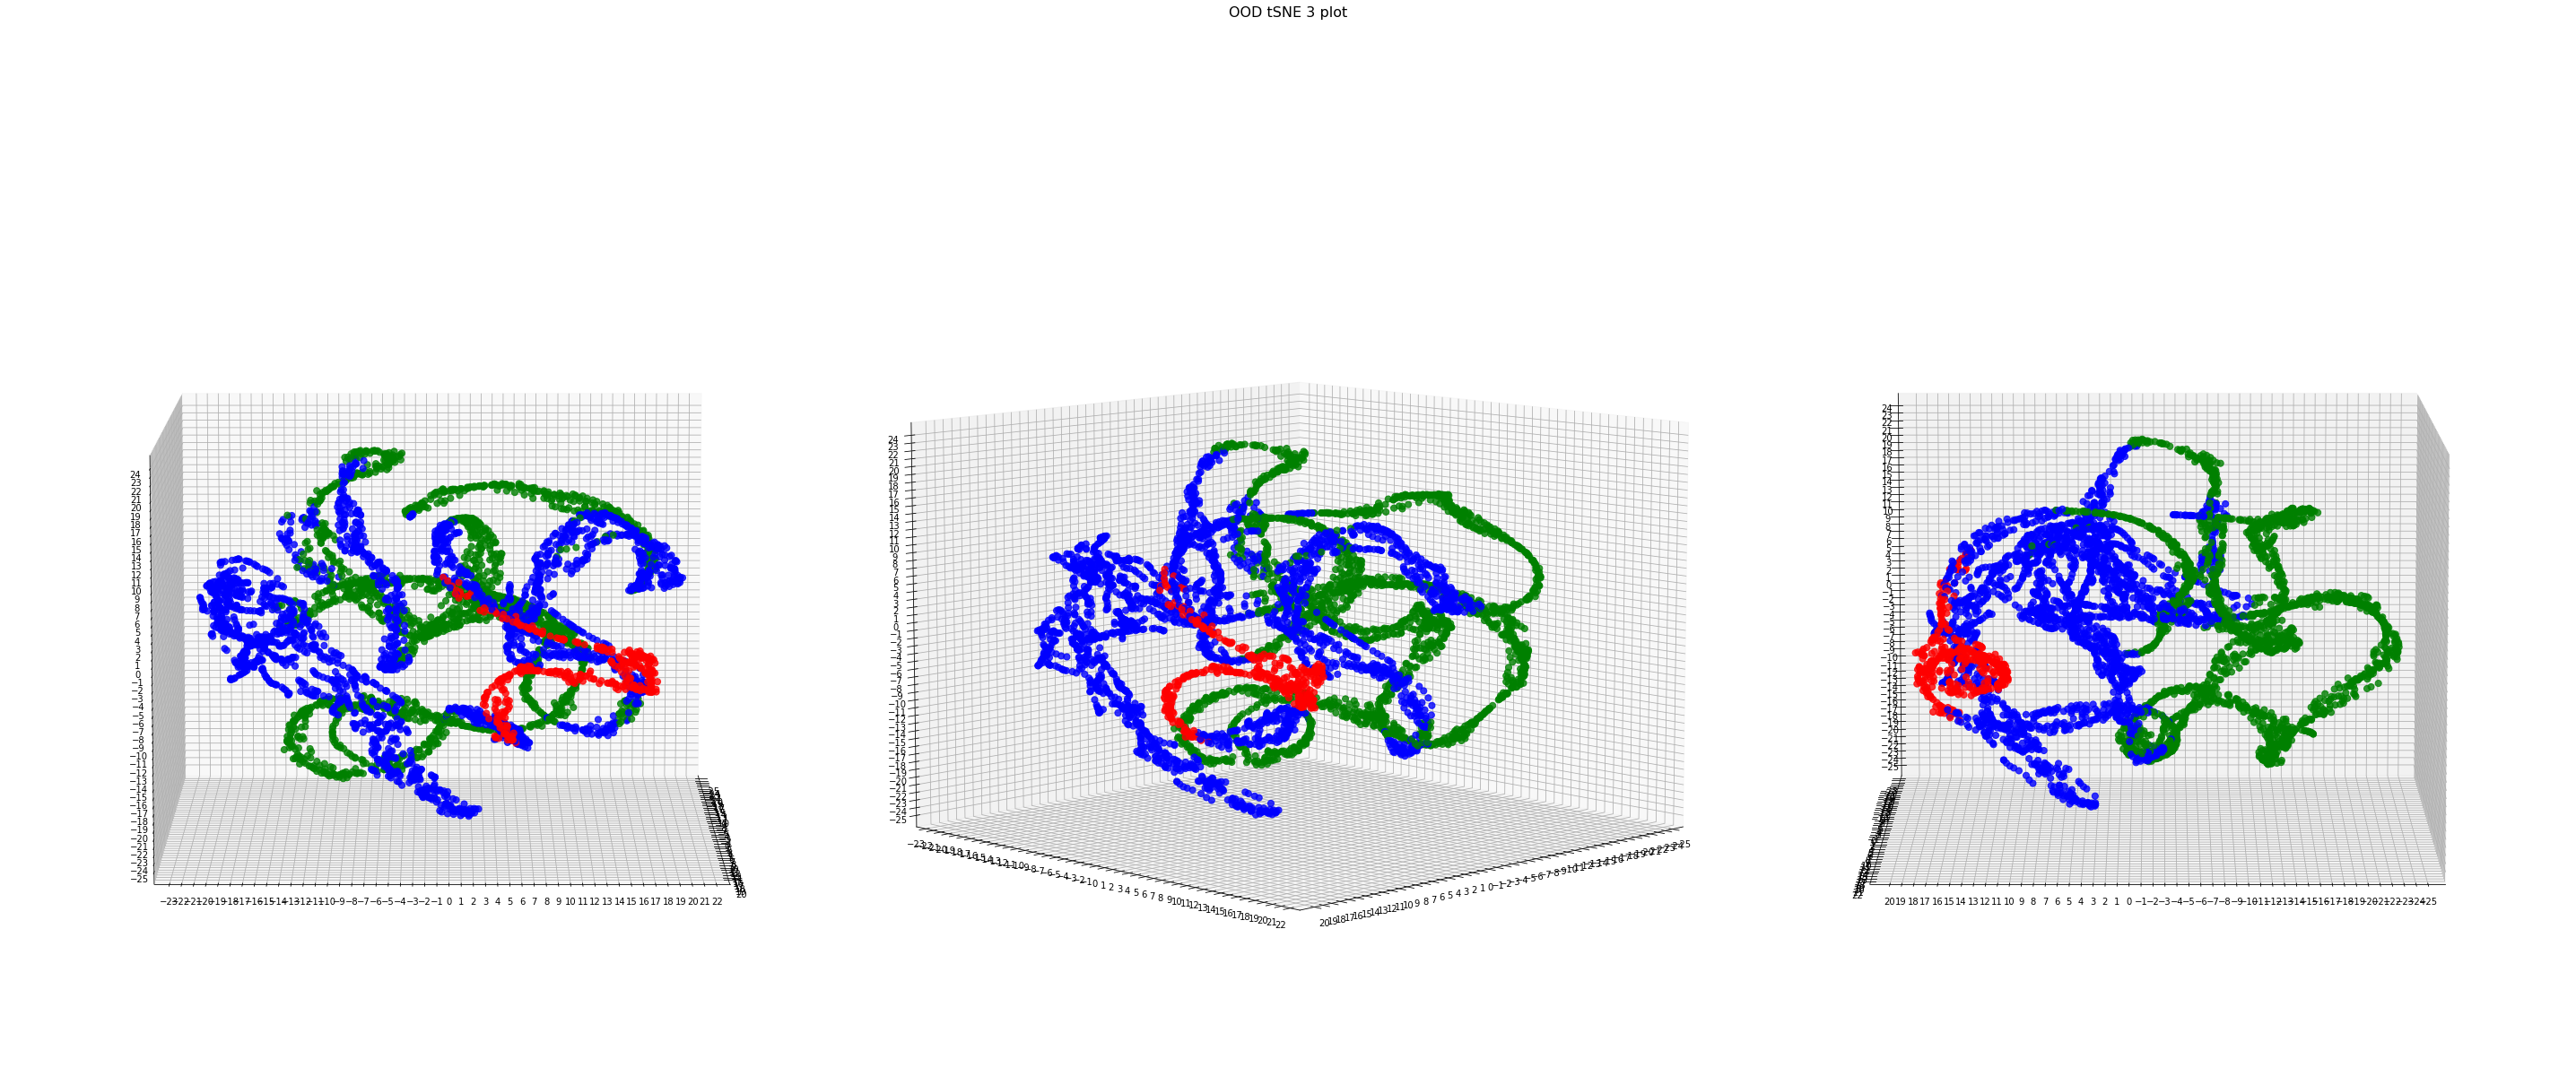

In [59]:

plot_3d(low_dim_ood.embedding_, slow_clazz[:half], 'OOD tSNE 3 plot')